In [1]:
import missingno as msno;from pprint import pprint;import pandas as pd;import matplotlib.pyplot as plt;import sklearn
import seaborn as sns; import numpy as np;from numpy.polynomial.polynomial import polyfit;from scipy.stats import linregress
from statsmodels.tsa.stattools import acf, pacf;from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA;from sklearn.metrics import mean_squared_error
import warnings; warnings.filterwarnings('ignore')
pd.set_option('display.show_dimensions',False)

# Data Cleaning

In [2]:
accidentsdf = pd.read_csv('../data/odot/Multnomah.csv',low_memory=False);accidentsdf.head(8)

,Crash ID,Record Type,Vehicle ID,Participant ID,Participant Display Seq#,Vehicle Coded Seq#,Participant Vehicle Seq#,Serial #,Crash Month,Crash Day,...,Participant Cause 1 Code,Participant Cause 2 Code,Participant Cause 3 Code,Participant Event 1 Code,Participant Event 2 Code,Participant Event 3 Code,BAC Test Results Code,Alcohol Use Reported,Drug Use Reported,Participant Striker Flag
0,1449628,1,NaN,NaN,NaN,NaN,NaN,149.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1449628,2,2741421.0,NaN,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1449628,3,2741421.0,3130945.0,1.0,1,1.0,NaN,NaN,NaN,...,13.0,,,,,,,,,0.0
3,1449628,2,2741422.0,NaN,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1449628,3,2741422.0,3130946.0,2.0,2,1.0,NaN,NaN,NaN,...,0.0,,,,,,,,,0.0
5,1449632,1,NaN,NaN,NaN,NaN,NaN,135.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1449632,2,2741429.0,NaN,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1449632,3,2741429.0,3130953.0,1.0,1,1.0,NaN,NaN,NaN,...,0.0,,,,,,,0,0,0.0


_There are a lot of empty values and the crash id appears to exist in more than one row._ 

<br>_Let's look at just one crash id:_

In [3]:
accidentsdf[accidentsdf['Crash ID'] == 1456243]

,Crash ID,Record Type,Vehicle ID,Participant ID,Participant Display Seq#,Vehicle Coded Seq#,Participant Vehicle Seq#,Serial #,Crash Month,Crash Day,...,Participant Cause 1 Code,Participant Cause 2 Code,Participant Cause 3 Code,Participant Event 1 Code,Participant Event 2 Code,Participant Event 3 Code,BAC Test Results Code,Alcohol Use Reported,Drug Use Reported,Participant Striker Flag
8765,1456243,1,NaN,NaN,NaN,NaN,NaN,1537.0,1.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8766,1456243,2,2753494.0,NaN,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8767,1456243,3,2753494.0,3144605.0,1.0,1,1.0,NaN,NaN,NaN,...,1.0,,,,,,,,,0.0
8768,1456243,2,2753495.0,NaN,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


__Missing Values Matrix__

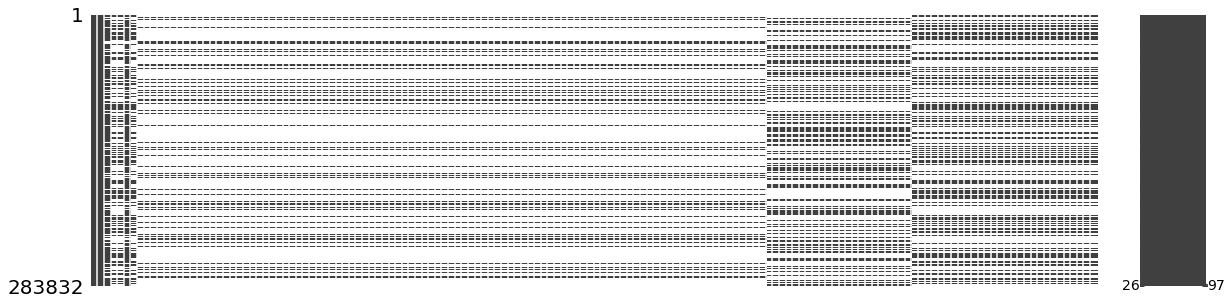

In [4]:
msno.matrix(accidentsdf,fontsize=12,figsize=(20,5));

_Each crash event appears to include multiple rows for each vehicle/participant/observer, but only one of those rows has data for most other features. This means we can't simply analyze the features as is and have to reduce the data either to the specific participants (2-3 per accident) or to the general accident report (1 per accident)._

<br>_To focus on bicycle accidents, I collect a few interesting features and select only rows with a 'Pedalcyclist' count of 1 or more:_

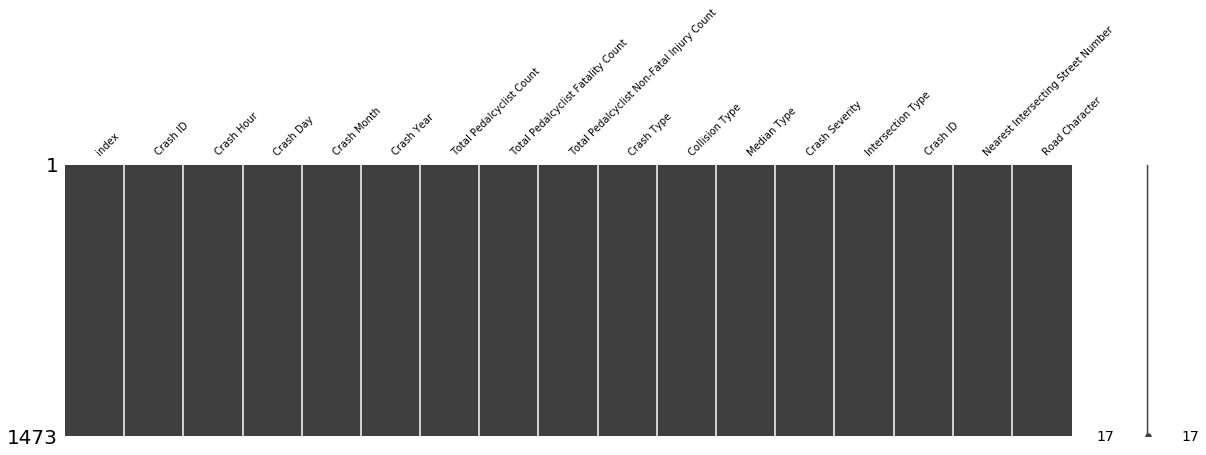

In [5]:
usedcol = ['Crash ID','Crash Hour','Crash Day','Crash Month','Crash Year','Total Pedalcyclist Count',
           'Total Pedalcyclist Fatality Count','Total Pedalcyclist Non-Fatal Injury Count','Crash Type',
           'Collision Type','Median Type','Crash Severity','Intersection Type','Crash ID',
           'Nearest Intersecting Street Number','Road Character']
bikeaccident = accidentsdf[usedcol][accidentsdf['Total Pedalcyclist Count']>0].dropna().reset_index()
bikeaccident.to_csv('bikeaccidents.csv');msno.matrix(bikeaccident,fontsize=10,figsize=(20,5));

_From this graph, we can see there are a total of 1473 reported ODOT bike related accidents in Multnomah county. This visual of missing data also looks much better. Each feature is solid with the exception of about 17 missing values._

In [6]:
bikeaccident.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Columns: 17 entries, index to Road Character
dtypes: float64(9), int64(3), object(5)
memory usage: 195.7+ KB


# Data Exploration

_Ok, now I want to explore the features. For example, is there a noticeable difference in time of day for which most accidents occur? My guess would be that most accidents take place when it is dark ~between 7pm-4am._

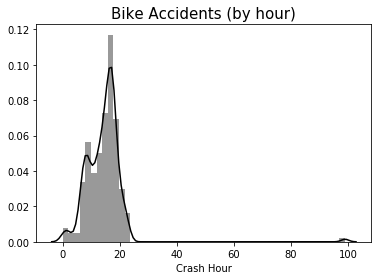

In [7]:
sns.distplot(bikeaccident['Crash Hour'],color = 'black');plt.title('Bike Accidents (by hour)',size=15);plt.show()

_It seems like there is a random value of 99 that occurs in the data 7 times. This is making the data harder to see, so let's remove it (temporarily). My guess is that 99 represents an unknown hour of the accident as 0 represents midnight._

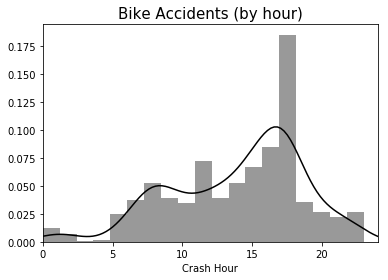

In [8]:
sns.distplot(bikeaccident['Crash Hour'][bikeaccident['Crash Hour']< 99],color='black');plt.xlim(0,24);plt.title('Bike Accidents (by hour)',size=15);plt.show()

_My prediction was wrong. It looks like most accidents happen around evening rush hour (4pm-6pm) with another peak at lunch time, and a third peak during morning rush hour(7am-9am). The data do not appear to be parametric._

<br>_So what about bike deaths? Bike Injuries?_

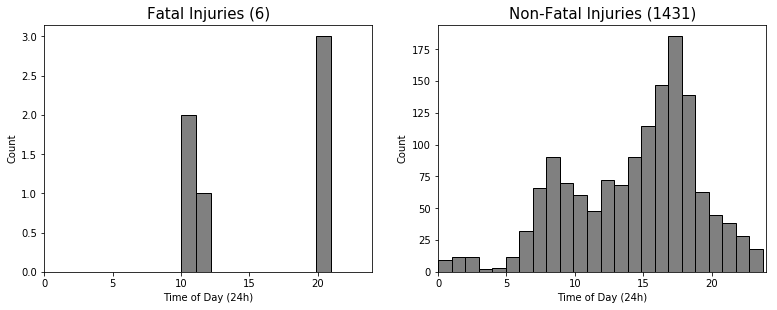

In [9]:
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.hist(bikeaccident['Crash Hour'][(bikeaccident['Total Pedalcyclist Fatality Count']>0)],
         color='gray',
         edgecolor='black')
plt.xlim(0,24)
plt.xlabel('Time of Day (24h)')
plt.ylabel('Count')
plt.title('Fatal Injuries ({})'.format(bikeaccident['index'][bikeaccident['Total Pedalcyclist Fatality Count']>0].count()), size=15)

plt.subplot(2,3,2)
plt.hist(bikeaccident['Crash Hour'][(bikeaccident['Total Pedalcyclist Non-Fatal Injury Count']>0)],
         bins=100, #not sure why I need to specify more than 24 bins here
         color='gray',
         edgecolor='black')
plt.xlim(0,24)
plt.title('Non-Fatal Injuries ({})'.format(bikeaccident['index'][bikeaccident['Total Pedalcyclist Non-Fatal Injury Count']>0].count()),size=15)
plt.xlabel('Time of Day (24h)')
plt.ylabel('Count')
plt.show()

_3 bike deaths happened at ~9pm, 2 deaths at ~11am, and 1 death at ~noon._

_Bike injuries account for almost all of the bike accident data (1431 out of 1473)._

In [10]:
bikeaccident.index = pd.to_datetime(
    bikeaccident['Crash Year']*10000+bikeaccident['Crash Month']*100+bikeaccident['Crash Day'],
    format='%Y%m%d')
bikeaccident = bikeaccident.drop(['Crash Year','Crash Day','Crash Month','Crash Hour','index'],axis=1);bikeaccident.head(3)

,Crash ID,Total Pedalcyclist Count,Total Pedalcyclist Fatality Count,Total Pedalcyclist Non-Fatal Injury Count,Crash Type,Collision Type,Median Type,Crash Severity,Intersection Type,Crash ID,Nearest Intersecting Street Number,Road Character
2012-01-07,1449752,1.0,0.0,1.0,6,6,,4.0,3,1449752,5220,1.0
2012-01-05,1450046,1.0,0.0,1.0,6,3,0,4.0,,1450046,1429,3.0
2012-01-03,1450073,1.0,0.0,1.0,6,3,,4.0,1,1450073,5019,1.0


In [11]:
# creating basic time series
ba = bikeaccident['Total Pedalcyclist Count'].groupby(pd.Grouper(freq='W')).count()

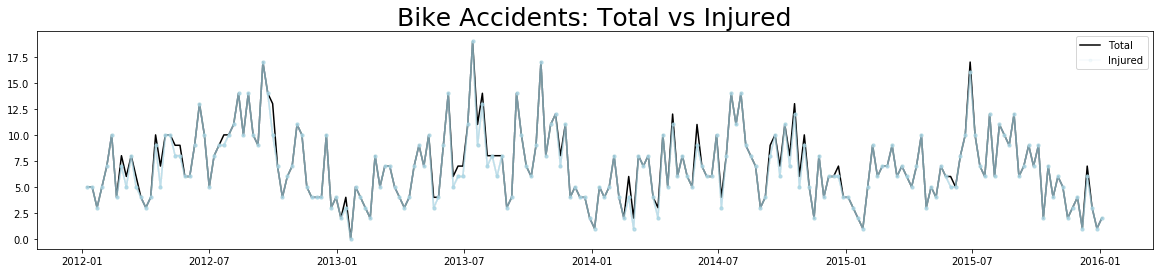

In [12]:
plt.figure(figsize=(20,4))
plt.plot(ba,color='black')
plt.plot(bikeaccident[bikeaccident['Total Pedalcyclist Non-Fatal Injury Count']>0].groupby(pd.Grouper(freq='W')).count(),
         color='lightblue',linestyle='-',alpha=.1,marker='.')
plt.legend(['Total','Injured']); plt.title('Bike Accidents: Total vs Injured',size=25);plt.show()

_The total number of bike accidents is pretty similar to the number of reported injuries per accident. It's probably safe to assume that accidents without injuries don't get reported as frequently. We can infer that this data is a sample subset of a greater unknown._

# Predictions

### [OLS] Ordinary Least Squares Linear Regression

_Now I want to build my baseline estimator (a straight line). I'll use RMSE as my metric for evaluation of my predictions._

__Formulas__

Line: $ y = a + bx $<br>
Standard Deviation: $ \sigma=\sqrt {\sum{\frac{(x-\bar{x})^2}n}} $ <br>
Pearson's Correllation Coefficient: $ r= \frac{\sum{(x_i - \bar{x})(y_i - \bar{y})}}{\sqrt{\sum{(x-\bar{x})^2}\sum{(y-\bar{y})^2}}} $<br>
Regression Slope: $ b=r\frac{\sigma_x}{\sigma_y} $ <br>
Root Mean Squared Error: $ \sqrt{\frac{\sum_{i=1}^n {(\hat{y}_{i}- y_{i})}^2}{N}} $

__Functions__

In [13]:
mean = lambda val: val.sum()/len(val)
dif = lambda val: val-mean(val)
r_value = lambda valx,valy:((dif(valx)*dif(valy)).sum())/((((dif(valx)**2).sum())*((dif(valy)**2).sum()))**.5)
std = lambda val:(mean((val-mean(val))**2))**.5
slope = lambda valx,valy: r_value(valx,valy)*std(valy)/std(valx)
intercept = lambda valx,valy: mean(y) - (slope(valx,valy)*mean(x))
RMSE = lambda y_predict, y_actual: np.sqrt(np.sum(np.square(np.subtract(y_predict,y_actual)))/len(y_actual))

__Calculations__

In [14]:
x,y = np.array(range(len(ba.values))),ba.values
x_mean,y_mean = mean(x),mean(y)
x_std,y_std = std(x),std(y)
r = r_value(x,y)
b = slope(x,y)
a = intercept(x,y)
print('Slope: {}\nIntercept: {}\nBaseline RMSE: {}'.format(b,a,RMSE(a+b*x,y)))

Slope: -0.006970660918029338
Intercept: 7.772795625427204
Baseline RMSE: 3.4101986894732423


_The RMSE value feels pretty high. Considering the data appears have a repeating pattern. I feel confident that I can get a lower RMSE value._

In [15]:
print('Statsmodels: Slope={} Intercept={}'.format(linregress(x,y).slope,linregress(x,y).intercept));print('Numpy: Slope={} Intercept={}'.format(polyfit(x, y, 1)[1],polyfit(x, y, 1)[0]))

Statsmodels: Slope=-0.006970660918029339 Intercept=7.772795625427204
Numpy: Slope=-0.006970660918029325 Intercept=7.772795625427202


_My calculations are the same as Statsmodels and Numpy's internal math! This is a good sign_

__Graph__

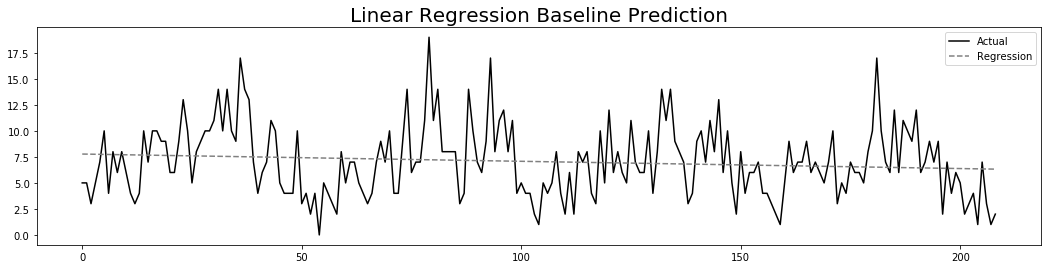

In [16]:
plt.figure(figsize=(18,4));plt.plot(x,y,color='black');plt.plot(x,a+b*x,color = 'gray',linestyle='--');
plt.legend(['Actual','Regression']);plt.title('Linear Regression Baseline Prediction',size=20);plt.show()

_The linear regression line appears to follow a downward trend in bike accidents from 2012-2015_

### [ACF/PACF] Auto and Partial Auto Correlation Functions

__Formulas__

Normalize Data: $ z_i=\frac{x_i-\min(x)}{\max(x)-\min(x)}$<br>
Covariance (sample): $ \frac{\sum {(x-x_\mu)}\cdot \sum{(y-y_\mu)}}{n-1} $<br>
Variance (sample): $ \sigma^2 = \frac{\sum{(x-x_\mu)^2}}{n-1} $<br>
ACF (2 variables): $ \rho = \frac{\hbox{cov}(x, y)}{\sigma_x \sigma_y} $<br>
ACF (1 variable): $ \rho(k=lag) = \frac{\frac{1}{n-k}\sum_{t=k+1}^n (y_t - \bar{y})(y_{t-k} - \bar{y})}{\sqrt{\frac{1}{n}\sum_{t=1}^n (y_t - \bar{y})}\sqrt{\frac{1}{n-k}\sum_{t=k+1}^n (y_{t-k} - \bar{y})}} $<br>
ACF (second example): $ r_{k} = \frac{\sum_{i=1}^{n-k}(y_{i} - \bar{y})(y_{i+k} - \bar{y})} {\sum_{i=1}^{n}(Y_{i} - \bar{y})^{2} } $<br>
PACF: $ \frac{cov(y,x_3|x_1,x_2)}{\sqrt{var(y|x_1,x_2)\cdot var(x_3|x_1,x_2)}} $

Resource: https://stats.stackexchange.com/questions/129052/acf-and-pacf-formula

__Functions__

In [17]:
norm = lambda val: (val-val.min())/(val.max()-val.min())
variance = lambda val: np.sum(((val-val.mean())**2)/(len(val)-1))
dev = lambda val: variance(val)**.5

__Calculations__

In [18]:
get_acf = acf(y,unbiased=True,nlags=len(y)-1)
get_pacf = pacf(y,nlags=len(y)-1, method='ols')

In [19]:
values = pd.DataFrame(ba.values)
values[0] = pd.to_numeric(values[0],errors='coerce')
dataframe = pd.concat([values.shift(3),values.shift(2),values.shift(1),values], axis=1).dropna()
dataframe.columns = ['t', 't+1','t+2','t+3']
dataframe.corr()

,t,t+1,t+2,t+3
t,1.000000,0.424448,0.345030,0.220210
t+1,0.424448,1.000000,0.429032,0.348564
t+2,0.345030,0.429032,1.000000,0.434542
t+3,0.220210,0.348564,0.434542,1.000000


__Graph__

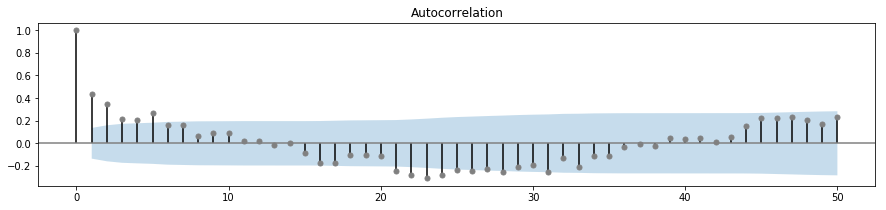

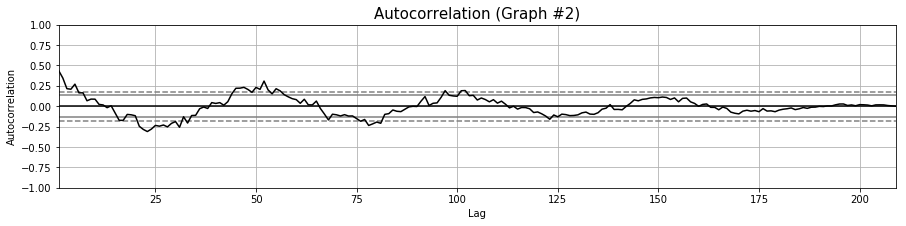

In [20]:
fig, ax = plt.subplots(figsize=(15, 3));plot_acf(y,color='gray',lags=50,ax=ax);plt.show()

plt.figure(figsize=(15,3));pd.plotting.autocorrelation_plot(y,color='black');plt.title('Autocorrelation (Graph #2)',fontsize=15);plt.show()

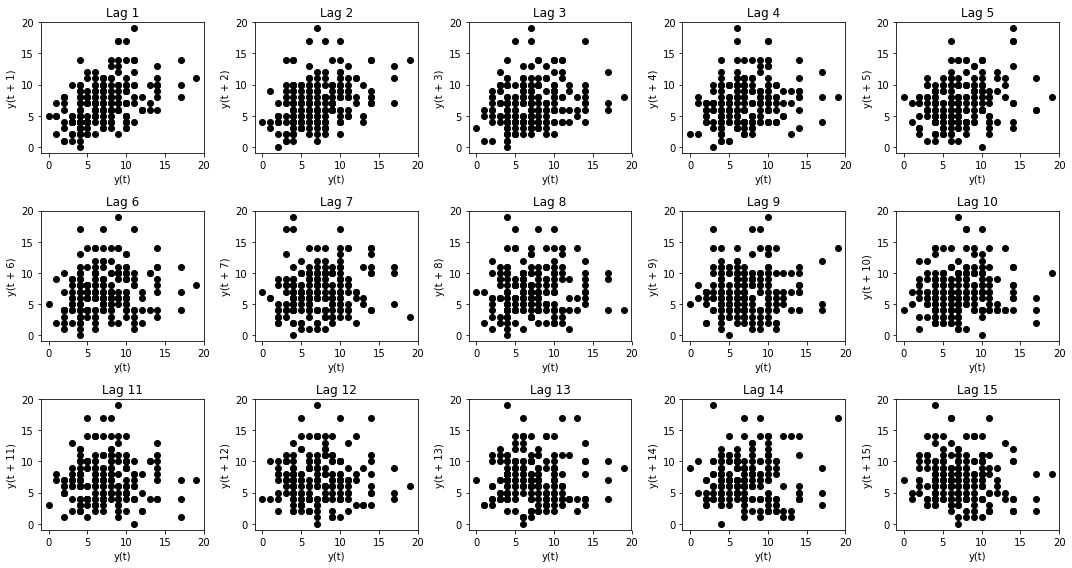

In [21]:
fig = plt.figure(figsize=(15,8))
for num in range(1,16):
    ax = fig.add_subplot(3,5,num)
    pd.plotting.lag_plot(ba,lag=num,c='black')
    ax.set_title('Lag {}'.format(num))

plt.tight_layout()
plt.show()

From Machine Learning Mastery:<br>
"The shape of the lag plot can provide clues about the underlying structure of your data. For example:<br>

<li>A linear shape to the plot suggests that an autoregressive model is probably a better choice.
<li>An elliptical plot suggests that the data comes from a single-cycle sinusoidal model."

_Lag Plot - Looks somewhat elliptical?_

### [AR] Auto Regressive Model

__Formulas__

$ \begin{equation*}  y_{t}=\beta_{0}+\beta_{1}y_{t-1}+\beta_{2}y_{t-2}+...+\epsilon_{t}  \end{equation*} $

$ \begin{equation}  \epsilon_{t}=\rho\epsilon_{t-1}+\omega_{t} \end{equation} $

$\begin{equation*}   \mbox{Corr}(\epsilon_{t},\epsilon_{t-1})=\frac{\mbox{Cov}(\epsilon_{t},\epsilon_{t-1})}{\sqrt{\mbox{Var}(\epsilon_{t})\mbox{Var}(\epsilon_{t-1})}}=\rho   \end{equation*} $

Resource: https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

In [22]:
X = ba

In [23]:
if len(dataframe.columns)>2:
    dataframe = dataframe.drop(['t+2','t+3'],axis=1)
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-10], X[len(X)-10:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

__Baseline AR Model (Predictions are 1 lag shift):__

Test MSE: 11.100


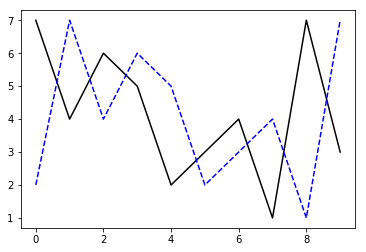

In [25]:
# persistence model
def model_persistence(x):
	return x
 
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
plt.plot(test_y,color='black')
plt.plot(predictions, color='blue',linestyle='--')
plt.show()

__AR Model (Predictions)__

Lag: 14
Coefficients: [ 2.82662967e+00  3.45162128e-01  1.65908892e-01 -3.11702593e-02
  1.49944523e-02  1.84156724e-01 -5.82681636e-02  6.72999613e-02
 -7.61001913e-02  3.06598626e-02  1.78047638e-02 -5.18020751e-02
 -2.11637101e-02 -3.40439459e-04  2.28834685e-02]
predicted=5.526580, expected=3.000000
predicted=4.865708, expected=4.000000
predicted=6.685162, expected=1.000000
predicted=5.910148, expected=7.000000
predicted=5.876275, expected=3.000000
predicted=6.637906, expected=1.000000
predicted=6.344214, expected=2.000000
Test MSE: 14.225


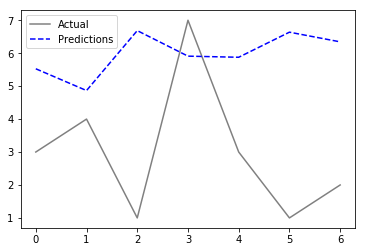

In [62]:
from statsmodels.tsa.ar_model import AR
X = values[0].tolist()
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
plt.plot(test,color='gray')
plt.plot(predictions, color='blue',linestyle='--')
plt.legend(['Actual','Predictions'])
plt.show()

### [MA] Moving Average Model

__Formulas__

Moving Average: $ \frac{a_m+a_{m-1}+...+a_{m-(n-1)}}{n} $

In [90]:
ma_range = 3
y_avg=[]
for i in r:
    if i > 10:
        y_avg.append((ba_val[i-10]+ba_val[i-9]+ba_val[i-8])/3)

3.7628088124073167


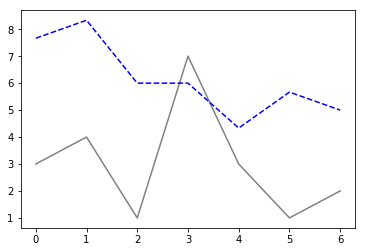

In [91]:
plt.plot(ba_val[-7:],color='gray')
plt.plot(y_avg[-7:],color='blue',linestyle='--')
print(RMSE(y_avg[-7:],ba_val[-7:]))

### [ARIMA] Auto Regressive Moving Average Model

t=0, predicted=6.0, expected=6.00

Test MSE: 4.858
ARIMA Prediction


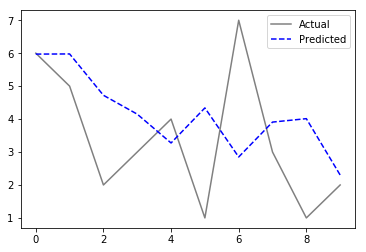

In [30]:
size = int(len(X) * 0.66)
train, test = X[1:len(X)-7], X[len(X)-7:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    if t%10 ==0:
        print('t=%.0f, predicted=%.1f, expected=%.2f' % (t,yhat, obs))
error = mean_squared_error(test, predictions)
print('\nTest MSE: %.3f' % error)
# plot
plt.plot(test,color='gray')
plt.plot(predictions, color='blue',linestyle='--');
plt.legend(['Actual','Predicted'])
print('ARIMA Prediction')